# **Helldivers2 analysis project**
data.world link

https://data.world/bethew/helldivers2-analysis

The goal of this project is to collect statistics about the different planets in the Helldivers2 online game, create an analysis, and present useful findings or correlations.

This project is made possible by the helldivers-2/api API.

This is a community made API which internally uses the semi-offical API used by ArrowHead studios.

You can learn more about this community based API here:
https://github.com/helldivers-2/api/blob/master/README.md

To consider historical information in my analysis, I also looked at articles from https://helldivers.fandom.com/wiki/Helldivers_Wiki


In this project I will include 3 CSV files for free use.


---



File A - Data extracted from the API approximately at the UTC time:  2025-02-24T00:20:10+00:00

---


File B - The cleaned data based off the original data

discards 'attacking', 'event', 'regenPerSecond', 'disabled', 'health', 'maxHealth', 'waypoints', 'position', 'hash', 'revives' fields from original dataset. Statistics dictionary field split into individual fields


---


File C - Same as File B, but in addition does not include abnormal Type-1 planets (learn more in the Transform section)

# API data license information

MIT License

Copyright (c) 2024 Helldivers 2 Community

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# **ETL (Extract, Transform, Load)**

In [183]:
# Libraries
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import json
import datetime
import pytz



## Extract
Here I will get JSON data from the helldivers-2/api API and convert into a Pandas dataframe.

The API requires an input a header with GET requests.


```
  header_dict ={
    'X-Super-Client':'Helldivers2 analysis project',
    'X-Super-Contact':'ethan.jnerd.eckmann@gmail.com'}
```



In [184]:
# Extract JSON data of planets from API and convert to dataframe of Helldivers 2 planets
# Optionally, download JSON file with UTC timestamp
def extraction_step(download_json=False):
  # Header needed for JSON request to be allowed
  header_dict ={
    'X-Super-Client':'Helldivers2 analysis project',
    'X-Super-Contact':'ethan.jnerd.eckmann@gmail.com'}

  # URL for the JSON get request
  planet_url = 'https://api.helldivers2.dev/api/v1/planets'

  # Method call to fetch planet data
  try:
    response = requests.get(planet_url, headers=header_dict)
    response.raise_for_status()
    # Planet_stats is now the parsed json data
    planet_stats = response.json()
  except requests.exceptions.RequestException as e:
    print(f'Request failed: {e}')
    return None
  except json.JSONDecodeError as e:
    print(f'JSON Decode Error: {e}')
    return None

  # Create Dataframe
  planet_dataframe = pd.DataFrame(planet_stats)

  # Timestamp to use for JSON file name
  timestamp = datetime.datetime.now()
  tz = pytz.timezone('UTC') # time zone
  aware_time = tz.localize(timestamp)

  filename = 'HD2_planetdata'+ aware_time.strftime("%Y%m%d_%H%M%S")+'.json'

  # Download JSON data
  if download_json == True:
    with open(filename, 'w') as out_file:
      json.dump(planet_stats, out_file, indent=4)

  # Return Dataframe
  return planet_dataframe


# Extract data from downloaded JSON data of planets file and convert to dataframe of Helldivers 2 planets
def extraction_step_file(file_name):
  try:
    with open(file_name, 'r') as f:
      file_data = json.load(f)
  except FileNotFoundError:
    print('Error: File not found.')
    return None
  except Exception as e:
    print(f'An unexpected error occurred: {e}')
    return None

  # Planet_stats is now the parsed json data
  planet_stats = file_data

  # Create Dataframe
  planet_dataframe = pd.DataFrame(planet_stats)

  # Return Dataframe
  return planet_dataframe


## Transform
Here I will process the dataframe to remove irrelevant data.
The data retrieved from the API GET request is mostly clean, but it does come with some data that either goes unused in-game (e.g., 'revives'), or is developer data not relevant to my analysis (e.g., 'hash').

Included in the data was the 'statistics' dictionary field, which contains key value pairs for planet statistics that are important for my analysis. I will convert each of these pairs to their own individual columns within the dataframe for ease of use in analysing the dataframe. The 'statistics' column will then be dropped because it would be redundant.


For a better analysis, I also want to define my own 'killDeathRatio' data field inside the dataframe.

---
Another problem I encountered with the data is that there are 2 types of planets in game that appear to have abnormalities in their statistics:

**Type-1.** extremly low statistics

**Type-2.** have killcounts of multiple factions but with a significant numerical difference between them.

I cannot say for sure what caused these abnormalities, but I suspect it to be the cause of game developer testing or because of illegal modders/hackers spawning in enemy types on planets where they would otherwise not exist.  

To prevent abnormal planets from effecting the end result of my analysis:

1. Filtered out the **Type-1** planets by discarding planets with a death killcount less than or equal to 1,000. This ensures that only planets that have been active in the game are taken into account.

2. Did not filter out the **Type-2** planets and continued to sum the kill counts of multiple factions of the  planets for my creation of the killDeathRatio field. I feel that this is the best option to accurately count the KD/ratio for planets that have legitimately had multiple factions fighting over them in the past, or might in the future.

Important to note that for the planet biome analysis I did not filter out either of the types of planets, as biome type is not affected by these statistical abnormalities.

In [185]:
# Cleans dataframe data
# Drops irrelevant columns
# Converts contents of 'statistics' dictionary type column to seperate columns
def transform_step(df):
  # Convert 'statistics' dictionary column to seperate columns
  # Extract keys and values to create the new columns
  df = df['statistics'].apply(pd.Series).join(df)
  new_cols_names = ['missionsWon', 'missionsLost', 'missionTime', 'terminidKills', 'automatonKills', 'illuminateKills', 'bulletsFired', 'bulletsHit', 'timePlayed', 'deaths', 'friendlies', 'missionSuccessRate', 'accuracy', 'playerCount']
  # Move new columns to the right side of the dataframe
  for i in new_cols_names:
    temp = df.pop(i)
    df.insert(len(df.columns), i, temp)

  # List of irrelevant data columns to be dropped from dataframe
  drop_col_list = ['attacking', 'event', 'regenPerSecond', 'disabled', 'health', 'maxHealth', 'waypoints', 'position', 'hash', 'statistics', 'revives']

  # New dataframe 'df_cleaned'
  df_cleaned = df.drop(drop_col_list, axis=1)

  # String columns will default to object type
  # We can change that to StringDtype for clarification
  df_cleaned['name'] = df['name'].astype('string')
  df_cleaned['sector'] = df['sector'].astype('string')
  df_cleaned['initialOwner'] = df['initialOwner'].astype('string')
  df_cleaned['currentOwner'] = df['currentOwner'].astype('string')

  # Create kd ratio column. Data is float64 rounded to 2 decimal places
  # This will be based upon total enemy kills for that planet / deaths for that planet
  df_cleaned['killDeathRatio'] = 0.0
  for index, row in df_cleaned.iterrows():
    terminidKills = row['terminidKills']
    automatonKills = row['automatonKills']
    illuminateKills = row['illuminateKills']
    deaths = row['deaths']

    try:
      df_cleaned.loc[index, 'killDeathRatio'] = round((terminidKills+automatonKills+illuminateKills)/deaths, 2)
      # If there are 0 deaths, kd = 0
    except ZeroDivisionError:
      df_cleaned.loc[index, 'killDeathRatio'] = 0.0

  return df_cleaned

# Does the same as transform_step(df), but also removes any entries from the dataframe with value 'deaths' <= death_cutoff parameter
def transform_step_alt(df, death_cutoff):
  df_cleaned_alt = transform_step(df)
  # Where deaths <= death_cutoff, remove row
  for index, row in df_cleaned_alt.iterrows():
    death_value = row['deaths']

    if death_value <= death_cutoff:
      df_cleaned_alt.drop(index, inplace=True)

  return df_cleaned_alt

# Analysis overview
Here I will:


1.   Analyze the data and present visualizations and  any surprising findings.

2.  Provide a data dictionary for all fields as well as basic descriptive statistics for numerical columns


Visualizations:
1.   Top 20 deadliest planets by player death count (bar graph)
2.   Top 20 most diffiuclt planets by kill/death ratio (bar graph)
3.   Top 20 most difficult planets by mission success rate (bar graph)
4.   Percent killed enemies from each faction (pie chart)
5.   Planet biomes (pie chart)
6.   Correlation between accuracy and mission success rate. Includes Pearson Correlation Coefficient (scatter plot)



## Analysis of data
For this section, I want to talk about any insights


---




1.   The deadliest planets

  I was surprised to learn that the deadliest planet in Helldivers2 was Rirga Bay. The Rirga Bay death count far surpasses all other planets in the galaxy, coming to a grand total just over 1 billion. In the game community, planets like Malevelon Creek and Calypso are often considered the places where the toughest battles have been fought, so this was extremely unexpected.

  I believe that the unnaturally high death count for Rirga Bay  may be caused by some sort of data manipulation through either a game bug or malicious hack during the planet's liberation. My reasoning for this is that the planet's KD ratio is 1.25. To me, this number seems far to low when hundreds of enemies are killed in an average HD2 game mission.


---


2.  The most difficult planets (KD ratio)

  If we discount Rirga Bay from our data, the top 3 most difficult planets by KD ratio are Tien Kwan, Malevelon Creek, and Draupnir. This ranking makes sense, as all three planets were major battlegrounds in various important in-game Major Orders. Tien Kwan was the planet where Operation Patriot was fought against the automatons, The infamous Malevelon Creek has seen 3 battles against the automatons, Draupnir has seen 7 battles against the automatons.

  This leads me to believe that the automatons are the most 'quality over quantity' in terms of unit types.


---


3. The most difficult planets (Mission Success Rate)

  When determining difficulty by mission success rate, we again see Tien Kwan, followed by Leng Secundus and Calypso. Calypso was the first planet invaded by the illuminate faction and home to a major battle, so its 3rd place ranking is logical. Leng Secundus's ranking suprises me due to the fact that it is a unnoteworthy planet in terms of battles fought.
  It is worth mentioning that out of the top 5 most difficult planets by mission success rate,

  TIEN KWAN fought automatons

  LENG SECUNDUS fought illuminate

  CALYPSO fought illuminate

  BOTEIN fought illuminate

  PÖPLI IX fought automatons.

  This leads me to believe that missions against automatons and illuminate are the most difficult to complete.


---


4.  Percent killed enemies from each faction

  From the pie chart, it is apparent that more Terminids(63.5%) have been killed than any other faction by a large margin. This makes sense, as the melee focused Terminids often rely on overpowering players through sheer numbers.
  The Automaton (24.4%) and Illuminate (12.1%) comparison is more interesting, as the illuminate faction has only recently been introduced in HD2 yet already has about half the percentage of the Automaton kills. This is likely due to the fact that the Illuminate attack using a mix of few high quality units and mobs of low quality units to attack players. The Automatons on the other hand, primarily focus on armies of heavy armored units.


---


5. Planet biomes

  This pie chart shows that there is a relatively even distribution of planet biomes in HD2.
  Super Earth is the only planet with an unknown biome. This could mean that either it will have a unique biome type in the future, or is not meant to have any battles fought upon it at all.



---

6. Accuracy vs Mission Success Rate
  
  The Pearsonr Pearson Correlation Coefficient for Accuracy vs Mission success rate is 0.2624876451986377.

  Or about 0.2625.
  
  This is considered a low correlation, meaning that a player's accuracy with their weapons does not necessarily mean they will have an easier time completing missions.




---
7. Importance and closing note

  Through my time spent on this data collection project I have learned many useful skills, such as API interaction and Visualization techniques. This is my first data science project, and I feel that I was able to successfully process data to gain useful insight into the Helldivers2 game.
  I hope that anyone who comes across this project wanting to create their own analysis will find it useful.






# Data dictionary and basic descriptive statistics

### Data dictionary for cleaned data
All fields non-null
Information for data fields follows this convention:

Name of field/column

Datatype according to dataframe

Description

---
'index'

int64

The index associated with a planet.


---



'name'

string

The planet's name.

---


'sector'

string

The sector the planet resides in. Sectors act like regions of space on the in-game map where multiple planets can be found.

---




'biome'

object

The biome of the planet. This field is a dictionary which contains key value pairs for 'name' and 'description'. The name is what the planet's biome is called. The description is consistent with the biome's name. For example, all Jungle biome planets will have the description: 'Abundant with life, this wet planet is covered in deep oceans, thick forests, and tall grasses'.


---



'hazards'

object

The hazards present on the planet. This field is a list of dictionaries which contains key value pairs for 'name' (the name of the hazard), and 'description' (the description of the hazard).


---


'initialOwner'

string

The name of the faction who initially owned the planet at the start of the current war.


---


'currentOwner'

string

The name of the faction who currently owns the planet.


---




'missionsWon'

int64

The total missions won for a planet. To consider a mission a win, a team of players must complete all primary objectives in a mission.


---




'missionsLost'

int64

The total missions lost for a planet. To consider a mission a loss, a team of players must fail at completing all primary objectives before the final mission time limit OR have depleted their avalible reinforcements with all players dead before completing all primary objectives.

---



'missionTime'

int64

The total time players have spent in missions on a planet in seconds. It is unclear if this number is being summed by accounting for each player for a mission, or each team of players for a mission.


---



'terminidKills'

int64

The amount of terminid faction enemies killed on a planet.


---



'automatonKills'

int64

The amount of automaton faction enemies killed on a planet.


---



'illuminateKills'

int64

The amount of illuminate faction enemies killed on a planet.



---



'bulletsFired'

int64

The amount of bullets fired on a planet. Note that some explosive weapons can hit multiple enemies in one 'bullet'. Note that it is possible (but unconfirmed) that the firing of a continous laser weapon may only count as one 'bulletsFired' but multiple 'bulletsHit'.


---


'bulletsHit'

int64

The amount of bullets that hit an enemy on a planet. Note that some explosive weapons can hit multiple enemies in one 'bullet'. Note that it is possible (but unconfirmed) that the firing of a continous laser weapon may only count as one 'bulletsFired' but multiple 'bulletsHit'.


---


'timePlayed'

int64

Identical to 'missionTime' field. Purpose is unclear, may simply be redundant data.


---


'deaths'

int64

Number of player deaths that have occured on a planet.

---


'revives'

int64

Unused data field. Purpose unclear.


---




'friendlies'

int64

Unclear meaning. Assumed to be friendly fire kills for a planet due to the fact that it always contains a value lower than the 'deaths' field value.

---


'missionSuccessRate'

int64

The rate (percent) of missions won divided by total missions * 100 for a planet


---


'accuracy'

int64

Percent calculated by 'bulletsHit' divided by 'bulletsFired' * 100. Capped at the value 100. Note that some explosive weapons can hit multiple enemies in one 'bullet'. Note that it is possible (but unconfirmed) that the firing of a continous laser weapon may only count as one 'bulletsFired' but multiple 'bulletsHit'. This often leads to a misleadingly high accuracy value for most planets

---


'playerCount'

int64

The amount of players currently located on a planet either in mission or on board their super destroyer at the time data was collected. Note that some planets will appear to have a playerCount value above 0 even when they are inaccessible in game. This may be due to developer testing or players logging off at a planet during a campaign.  

---


'killDeathRatio'

float64

Field not originally from the API. Created for data analysis in this project, but also included in CSV files 'B' and 'C' for ease of use in any later analysis by others. Calculated by the sum of 'terminidKills', 'automatonKills', and 'illuminateKills' divided by 'deaths' in a planet.


---



Notes and known issues:

  The 'accuracy' field is misleading. Upon viewing the CSV file, you may notice that for some planets 'bulletsHit' is greater than 'bulletsFired'. This discrepancy can be attributed to:

  1. The fact that some explosive weapons can hit multiple enemies in a single shot
  2. The possibility that continuous beam weapons being triggered may only count as one 'bulletsFired', but multiple 'bulletsHit'

The 'revives' field from the original data is a mystery. On nearly all planets it is 0, otherwise it is some other low number. My best guess is that this was a data field that went unused by the game developers. For this reason I dropped the 'revives' field for CSV files 'B' and 'C' and did not include it in the basic descriptive statistics

The 'killDeathRatio' field is not originally from the API request. I made this field myself based off of the values of 'kills' for each faction summed together and divided by the 'deaths' for each planet. Keep in mind that Type 2 abnormality planets (read more at transform step) can influence results slightly if you want to analyize the KD ratios in comparison to the majority enemy faction fought against on a planet.




---


### Basic descriptive statistics

Column: missionsWon, Mean: 2947428.6447368423, Median: 685883.5, Standard Deviation: 4891432.995008219

Column: missionsLost, Mean: 286716.8355263158, Median: 68027.5, Standard Deviation: 482912.785930131

Column: missionTime, Mean: 8821155483.18421, Median: 2728071205.0, Standard Deviation: 13514643492.776344

Column: terminidKills, Mean: 658300445.4210526, Median: 68.5, Standard Deviation: 1755870454.3587348

Column: automatonKills, Mean: 253113672.2368421, Median: 0.0, Standard Deviation: 586450263.3308883

Column: illuminateKills, Mean: 124886401.73684211, Median: 0.0, Standard Deviation: 299996483.1477079

Column: bulletsFired, Mean: 4865439373.888158, Median: 1671433670.5, Standard Deviation: 7940485298.025093

Column: bulletsHit, Mean: 5464466925.585526, Median: 1661897165.0, Standard Deviation: 9404459834.530785

Column: timePlayed, Mean: 8821155483.18421, Median: 2728071205.0, Standard Deviation: 13514643492.776344

Column: deaths, Mean: 27275873.32236842, Median: 5322938.0, Standard Deviation: 85893524.53641756

Column: friendlies, Mean: 2986208.3157894737, Median: 869866.5, Standard Deviation: 5029021.415725135

Column: missionSuccessRate, Mean: 89.73026315789474, Median: 90.0, Standard Deviation: 2.698958334104047

Column: accuracy, Mean: 98.15789473684211, Median: 100.0, Standard Deviation: 2.7527355765509336

Column: playerCount, Mean: 574.7631578947369, Median: 3.0, Standard Deviation: 5118.565304650456

Column: killDeathRatio, Mean: 63.50072368421053, Median: 65.04499999999999, Standard Deviation: 26.890339438206283


In [186]:
# Basic statistics for all numerical columns
def get_basic_stats(df):
  numerical_column_list = ['missionsWon', 'missionsLost', 'missionTime', 'terminidKills', 'automatonKills', 'illuminateKills', 'bulletsFired', 'bulletsHit', 'timePlayed', 'deaths', 'friendlies', 'missionSuccessRate', 'accuracy', 'playerCount', 'killDeathRatio']
  for col in numerical_column_list:
    mean = df[col].mean()
    median = df[col].median()
    standard_deviation = df[col].std()
    print(f'Column: {col}, Mean: {mean}, Median: {median}, Standard Deviation: {standard_deviation}')

## The 20 deadliest planets by player death count

In [187]:
def deadliest_planets(df, planet_limit):
  top = df.sort_values(by=['deaths'], ascending=False).head(planet_limit) # Get top planets as limited by planet_limit parameter
  plt.bar(top['name'], top['deaths'], color='red')

  # Create the bar graph
  plt.title(f'{planet_limit} Deadliest planets', fontdict={'fontsize': 16, 'fontweight': 'bold'})
  plt.xlabel('Planet')
  plt.ylabel('Deaths')
  plt.gca().yaxis.set_major_formatter(lambda x, pos: f'{x/1000000000:.1f}B') # display yaxis in billions
  plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
  plt.show()

## Top 20 most diffiuclt planets by kill/death ratio

In [188]:
def difficult_planets_kd(df, planet_limit):
  top = df.sort_values(by=['killDeathRatio'], ascending=True).head(planet_limit) # Get top planets as limited by planet_limit parameter
  plt.bar(top['name'], top['killDeathRatio'], color='skyblue')

  # Create the bar graph
  plt.title(f'{planet_limit} Most difficult planets (K/D ratio)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
  plt.xlabel('Planet')
  plt.ylabel('Kill/Death')
  plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
  plt.show()

## Top 20 most difficult planets by mission success rate

In [189]:
def difficult_planets_ms(df, planet_limit):
  top = df.sort_values(by=['missionSuccessRate'], ascending=True).head(planet_limit) # Get top planets as limited by planet_limit parameter
  plt.bar(top['name'], top['missionSuccessRate'], color='gold')

  # Create the bar graph
  plt.title(f'{planet_limit} Most difficult planets (mission success rate)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
  plt.xlabel('Planet')
  plt.ylabel('Mission success rate')
  plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
  plt.show()

## Percent killed enemy factions

In [190]:
def most_killed_factions(df):
  t = df['terminidKills'].sum() # terminid killed
  a = df['automatonKills'].sum() # automaton killed
  i = df['illuminateKills'].sum() # illuminate Killed
  faction_list = [t, a, i]
  labels_list=['Terminid', 'Automaton', 'Illuminate']
  colors_list = ['gold', 'grey', 'purple']

  plt.pie(faction_list, labels=labels_list, colors=colors_list, autopct='%1.1f%%')
  plt.title('Percent killed enemy factions', fontdict={'fontsize': 16, 'fontweight': 'bold'})
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
  plt.show()

## Planet biomes

In [191]:
def planet_biomes(df):
  biome_list = []
  biome_freq_list = []
  for index, row in df.iterrows():
    biome = row['biome'].get('name')
    biome_list.append(biome)

  unique_biome_list = list(set(biome_list)) # make list of unique biomes

  for i in unique_biome_list:
    biome_freq_list.append(biome_list.count(i)) # the numerical frequency of biomes

  plt.pie(biome_freq_list, labels=unique_biome_list, autopct='%1.1f%%')
  plt.title('Planet biomes', fontdict={'fontsize': 16, 'fontweight': 'bold'})
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
  plt.axis('equal')
  plt.show()

## Correlation between accuracy and mission success rate

In [192]:
def accuracy_and_ms(df):

  x_axis = df['accuracy']
  y_axis = df['missionSuccessRate']

  # Pearsonr Pearson Correlation Coefficient
  p = pearsonr(df['accuracy'], df['missionSuccessRate'])

  plt.scatter(x_axis,y_axis, marker='o')
  plt.xlabel('Accuracy')
  plt.ylabel('Mission success rate')
  plt.title('Accuracy vs Mission success rate', fontdict={'fontsize': 16, 'fontweight': 'bold'})
  plt.show()
  print(f'The Pearsonr Pearson Correlation Coefficient for Accuracy vs Mission success rate = {p[0]}\n')


## Extra functions

In [193]:
# Extra functions

# Prints datatypes of all columns in a dataframe
def get_datatypes(df):
  print(df.dtypes)
  print(df.info())

# Returns list of deadliest planets and their rank. Lower number rank means higher deaths
def rank_death_planets(df):
  rank_list = []     #[{'rank': 1, 'name': 'RIRGA BAY', 'deaths': '1002799434', ...]}
  total_planets = len(df)
  rank = 1

  ranked = df.sort_values(by=['deaths'], ascending=False)
  for index, row in ranked.iterrows():

    entry_dict = {'rank':(str(rank)),'name':row['name'],'deaths':str(row['deaths'])}
    rank_list.append(entry_dict)
    rank += 1

  return rank_list

# Returns list of most difficult planets by kd ratio and their rank. Lower number rank means higher kd
def rank_kd_planets(df):
  rank_list = []
  total_planets = len(df)
  rank = 1

  ranked = df.sort_values(by=['killDeathRatio'], ascending=False)
  for index, row in ranked.iterrows():

    entry_dict = {'rank':(str(rank)),'name':row['name'],'k/d':str(row['killDeathRatio'])}
    rank_list.append(entry_dict)
    rank += 1

  return rank_list

# Returns list of most difficult planets by mission success rate and their rank. Lower number rank means mission success rate
def rank_ms_planets(df):
  rank_list = []
  total_planets = len(df)
  rank = 1

  ranked = df.sort_values(by=['missionSuccessRate'], ascending=False)
  for index, row in ranked.iterrows():

    entry_dict = {'rank':(str(rank)),'name':row['name'],'mission success rate':str(row['missionSuccessRate'])}
    rank_list.append(entry_dict)
    rank += 1

  return rank_list

# Finds the rank of a planet based off its name. Can be used for any type of ranked list
def find_rank(rank_list, planet_name):
  planet_rank = 0
  for my_dict in rank_list:
      if my_dict['name'].lower() == planet_name.lower(): # if found planet
        planet_rank = my_dict['rank']

  return planet_rank, planet_name

# Gets the planet with the lowest accuracy value
def get_least_accurate(df, n):
  ranked = df.sort_values(by=['accuracy'], ascending=True).head(n)
  name_list = []
  for index, row in ranked.iterrows():
    name_list.append(row['name'])
  return name_list

# Gets the planet with the mission success rate
def get_least_successful(df, n):
  ranked = df.sort_values(by=['missionSuccessRate'], ascending=True).head(n)
  name_list = []
  for index, row in ranked.iterrows():
    name_list.append(row['name'])
  return name_list

## Function Calls and Load step
Here I will load my cleaned data into a CSV file for others to view and use.
Functions previously seen in the project are called here.



In [194]:
def load_step(df, string_name):
  # Dataframe to CSV
  df.to_csv(string_name + '.csv', header=True, index=False)



Basic descriptive statistics for all fields
Column: missionsWon, Mean: 2947428.6447368423, Median: 685883.5, Standard Deviation: 4891432.995008219
Column: missionsLost, Mean: 286716.8355263158, Median: 68027.5, Standard Deviation: 482912.785930131
Column: missionTime, Mean: 8821155483.18421, Median: 2728071205.0, Standard Deviation: 13514643492.776344
Column: terminidKills, Mean: 658300445.4210526, Median: 68.5, Standard Deviation: 1755870454.3587348
Column: automatonKills, Mean: 253113672.2368421, Median: 0.0, Standard Deviation: 586450263.3308883
Column: illuminateKills, Mean: 124886401.73684211, Median: 0.0, Standard Deviation: 299996483.1477079
Column: bulletsFired, Mean: 4865439373.888158, Median: 1671433670.5, Standard Deviation: 7940485298.025093
Column: bulletsHit, Mean: 5464466925.585526, Median: 1661897165.0, Standard Deviation: 9404459834.530785
Column: timePlayed, Mean: 8821155483.18421, Median: 2728071205.0, Standard Deviation: 13514643492.776344
Column: deaths, Mean: 27

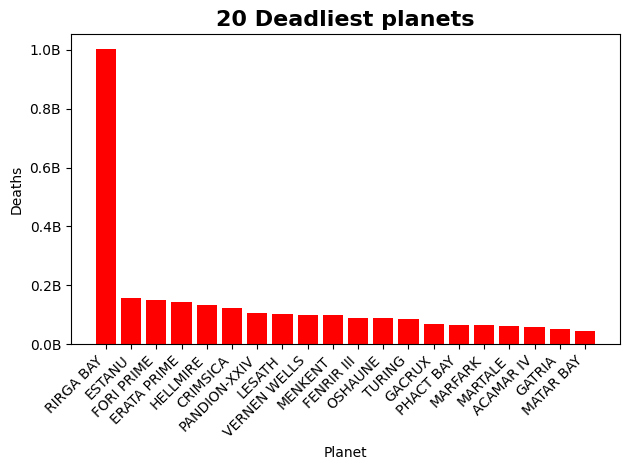

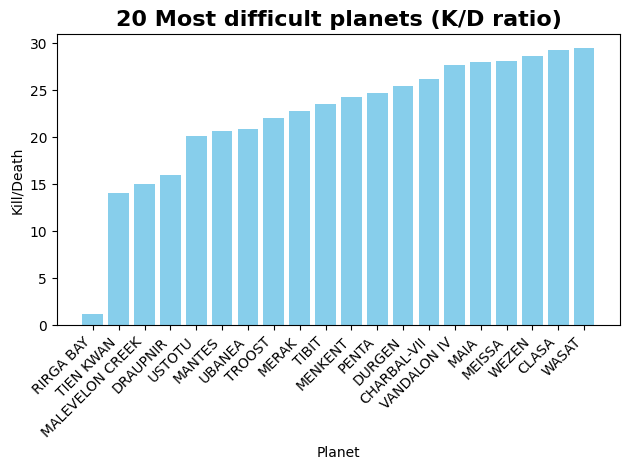

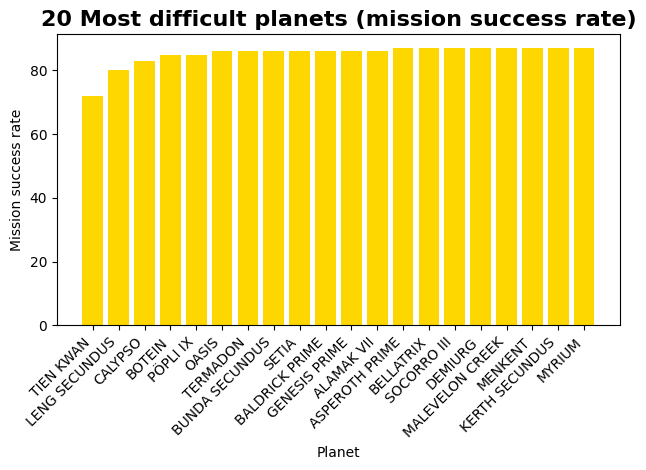

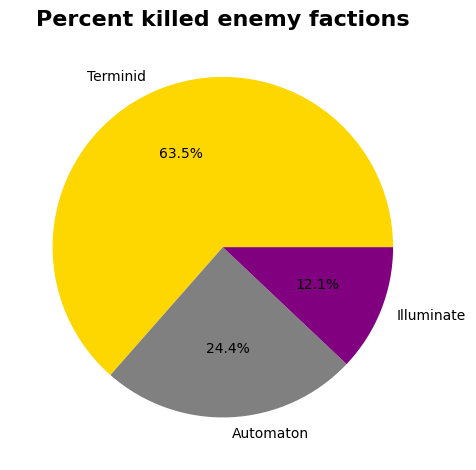

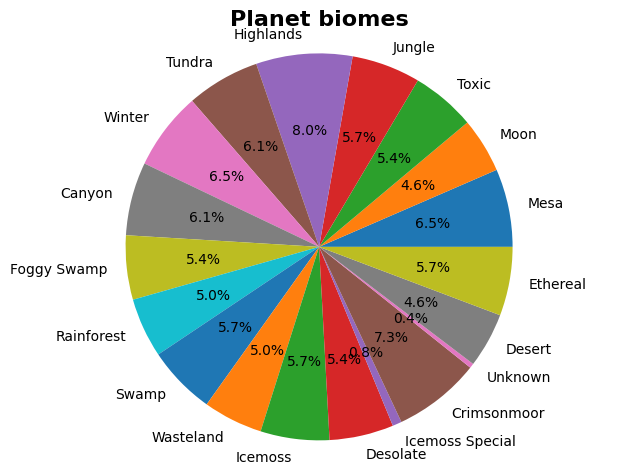

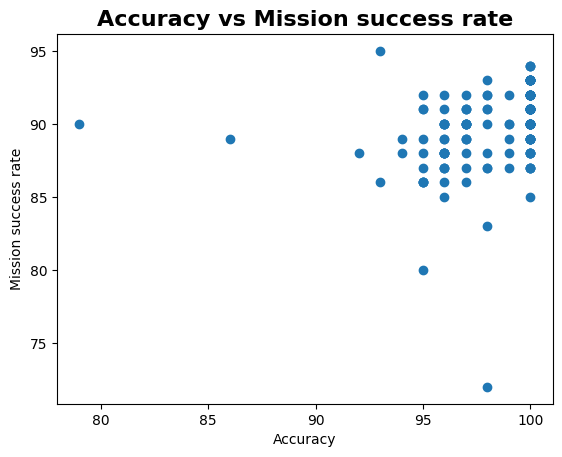

The Pearsonr Pearson Correlation Coefficient for Accuracy vs Mission success rate = 0.2624876451986377



In [195]:
# Extract from API HTTP request
# original_df = extraction_step(download_json=True) # if download_json = True, download the JSON data in addition to creating the dataframe

# Extract from previously downloaded JSON file
original_df = extraction_step_file(file_name='HD2_planetdata20250224_002010.json')

# Transform steps using API call
clean_df = transform_step(original_df)
clean_df_alt = transform_step_alt(original_df, death_cutoff=1000) # alt cleaning, discards planets with less than or equal deaths to death_cutoff

# Basic stats for all columns
# Based off the same data as CSV file 'C'
print('\n')
print('Basic descriptive statistics for all fields')
get_basic_stats(clean_df_alt)
print('\n')

# Information about number of planet entries
print('\n')
print('Information about number of planet entries')
print(f'Planet entries in original = {len(original_df)}')
print(f'Planet entries in cleaned = {len(clean_df)}')
print(f'Planet entries in cleaned_alt (some dropped planets) = {len(clean_df_alt)}')
print(f'Difference in planet entries between cleaned and cleaned_alt = {len(clean_df) - len(clean_df_alt)}')
print('\n')

# Visualizations
deadliest_planets(clean_df_alt, planet_limit=20) # bar graph
difficult_planets_kd(clean_df_alt, planet_limit=20) # bar graph
difficult_planets_ms(clean_df_alt, planet_limit=20) # bar graph
most_killed_factions(clean_df_alt) # pie chart
planet_biomes(clean_df) # pie chart
accuracy_and_ms(clean_df_alt) # scatter plot

# Optional methods

# get_datatypes(clean_df)

# rank_list_1 = rank_death_planets(clean_df_alt) # get list of ranks of planets by deaths
# print(f'Rank list by death field: {rank_list_1}')

# rank_list_2 = rank_kd_planets(clean_df_alt) # get list of ranks of planets by kd ratio
# print(f'Rank list by kd ratio field: {rank_list_2}')

# rank_list_3 = rank_ms_planets(clean_df_alt) # get list of ranks of planets by mission success rate
# print(f'Rank list by mission success rate field: {rank_list_3}')

# r1, n1 = find_rank(rank_list_1, planet_name='MALEVELON CREEK') # find rank of a planet
# print(f'Planet {n} has rank of {r}')

# n2 = 10
# x = get_least_accurate(clean_df_alt, n=n2) # get n least accurate planets
# print(f'The {n2} least accurate planets: {x}')

# y = get_least_successful(clean_df_alt, n=10) # get n least successful planets
# print(f'The {n2} least successful planets: {y}')


# Load step
load_step(original_df, 'Helldivers2_planet_stats_A') # CSV A - original data csv
load_step(clean_df, 'Helldivers2_planet_stats_B') # CSV B - cleaned data
load_step(clean_df_alt, 'Helldivers2_planet_stats_C') # CSV C - alternate cleaned data CSV (does not include abnormal type 1)